## Github data
We may be able to develop a benchmark based on Github data from https://www.gharchive.org/

To download, use e.g.
```
	wget https://data.gharchive.org/2015-01-{01..31}-{0..23}.json.gz
```

In [1]:
!mkdir -p data

In [5]:
!which wget || brew install wget

wget not found
Updating Homebrew...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> New Formulae
all-repos                  git-svn                    libsigrok
charmcraft                 gitlab-ci-local            ncnn
copier                     jellyfish                  node@16
==> Updated Formulae
Updated 1012 formulae.

==> Downloading https://ghcr.io/v2/homebrew/core/wget/manifests/1.21.2
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/wget/blobs/sha256:7a8e6512e0890
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Pouring wget--1.21.2.big_sur.bottle.tar.gz
🍺  /usr/local/Cellar/wget/1.21.2: 89 files, 4.2MB


In [8]:
#!cd data && wget https://data.gharchive.org/2015-01-{01..31}-{0..23}.json.gz

In [7]:
# Analysis of files

# -> how many fields?
# -> data length?
# max nested level?
# shortest array length, longest array length?

# for string pooling? ==> separate analysis

In [9]:
def compute_statistics(path):
    assert path.endswith('.gz')

In [16]:
import gzip
import json

path = 'data/2015-01-01-0.json.gz'

fp = gzip.open(path, 'rb')
lines = fp.readlines()
lines = [json.loads(line) for line in lines]

In [18]:
lines[0]

{'id': '2489368070',
 'type': 'PushEvent',
 'actor': {'id': 9152315,
  'login': 'davidjhulse',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/davidjhulse',
  'avatar_url': 'https://avatars.githubusercontent.com/u/9152315?'},
 'repo': {'id': 28635890,
  'name': 'davidjhulse/davesbingrewardsbot',
  'url': 'https://api.github.com/repos/davidjhulse/davesbingrewardsbot'},
 'payload': {'push_id': 536740396,
  'size': 1,
  'distinct_size': 1,
  'ref': 'refs/heads/master',
  'head': 'a9b22a6d80c1e0bb49c1cf75a3c075b642c28f81',
  'before': '86ffa724b4d70fce46e760f8cc080f5ec3d7d85f',
  'commits': [{'sha': 'a9b22a6d80c1e0bb49c1cf75a3c075b642c28f81',
    'author': {'email': 'da8d7d1118ca5befd4d0d3e4f449c76ba6f1ee7e@live.com',
     'name': 'davidjhulse'},
    'message': 'Altered BingBot.jar\n\nFixed issue with multiple account support',
    'distinct': True,
    'url': 'https://api.github.com/repos/davidjhulse/davesbingrewardsbot/commits/a9b22a6d80c1e0bb49c1cf75a3c075b642c28f81'}]},
 'p

In [19]:
# create json stats
obj = lines[0]

In [26]:
def json_stats(obj):
    stats = {}

    stats['keys'] = len(obj.keys())
    stats['max_nesting'] = 0
    stats['max_array_length'] = 0
    
    for k, v in obj.items():
        if isinstance(v, dict):
            sub_stats = json_stats(v)
            
            # combine stats
            stats['keys'] += len(v.keys())
            stats['max_nesting'] = 1 + sub_stats['max_nesting']
            stats['max_array_length'] = max(sub_stats['max_array_length'], stats['max_array_length'])
            
        if isinstance(v, list):
            stats['max_array_length'] = max(stats['max_array_length'], len(v))
            for el in v:
                if isinstance(v, dict):
                    sub_stats = json_stats(v)
                    
                    # combine stats
                    stats['keys'] += len(v.keys())
                    stats['max_nesting'] = 1 + sub_stats['max_nesting']
                    stats['max_array_length'] = max(sub_stats['max_array_length'], stats['max_array_length'])
    
    return stats

In [27]:
json_stats(obj)

{'keys': 22, 'max_nesting': 1, 'max_array_length': 1}

In [30]:
from tqdm import tqdm

In [31]:
rows = []

for line in tqdm(lines):
    row = json_stats(line)
    row['path'] = path
    
    rows.append(row)

100%|███████████████████████████████████████████████| 7702/7702 [00:00<00:00, 58517.40it/s]


In [40]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

In [36]:
df = pd.DataFrame(rows)

In [41]:
df

,keys,max_nesting,max_array_length,path
0,22,1,1,data/2015-01-01-0.json.gz
1,22,1,1,data/2015-01-01-0.json.gz
2,20,1,0,data/2015-01-01-0.json.gz
3,28,1,8,data/2015-01-01-0.json.gz
4,22,1,1,data/2015-01-01-0.json.gz
...,...,...,...,...
7697,17,3,0,data/2015-01-01-0.json.gz
7698,20,1,0,data/2015-01-01-0.json.gz
7699,22,1,0,data/2015-01-01-0.json.gz
7700,16,1,1,data/2015-01-01-0.json.gz


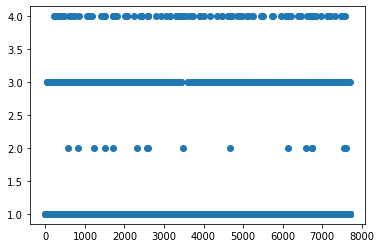

In [43]:
plt.scatter(df.index, df['max_nesting'])

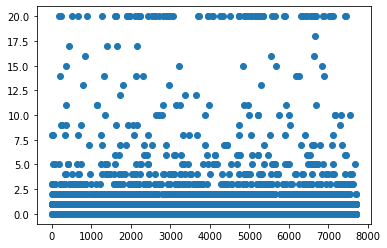

In [44]:
plt.scatter(df.index, df['max_array_length'])

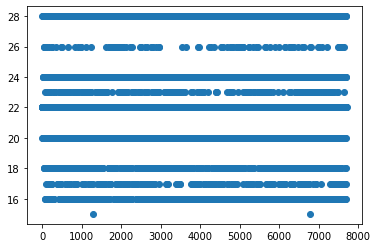

In [45]:
plt.scatter(df.index, df['keys'])

In [48]:
def analyze_path(path):
    fp = gzip.open(path, 'rb')
    lines = fp.readlines()
    lines = [json.loads(line) for line in lines]
    
    rows = []
    for i, line in enumerate(lines):
        row = json_stats(line)
        row['path'] = path
        row['lineno'] = i
        rows.append(row)
    return pd.DataFrame(rows)

In [47]:
import glob

In [51]:
df = pd.DataFrame()
for path in tqdm(sorted(glob.glob('data/*.gz'))):
    df = pd.concat((df, analyze_path(path)))

100%|████████████████████████████████████████████████████| 742/742 [16:16<00:00,  1.32s/it]


In [52]:
df.to_csv('analysis.csv', index=False)

In [57]:
df_agg = df.groupby('path').agg(['min', 'max']).reset_index()

In [58]:
df_agg

path keys     max_nesting     max_array_length      \
                                 min max         min max              min max   
0     data/2015-01-01-0.json.gz   15  28           1   4                0  20   
1     data/2015-01-01-1.json.gz   15  28           1   4                0  40   
2    data/2015-01-01-10.json.gz   15  28           1   4                0  20   
3    data/2015-01-01-11.json.gz   15  28           1   4                0  20   
4    data/2015-01-01-12.json.gz   15  28           1   4                0  20   
..                          ...  ...  ..         ...  ..              ...  ..   
737   data/2015-01-31-5.json.gz   15  28           1   4                0  20   
738   data/2015-01-31-6.json.gz   15  28           1   4                0  20   
739   data/2015-01-31-7.json.gz   15  28           1   4                0  20   
740   data/2015-01-31-8.json.gz   15  28           1   4                0  20   
741   data/2015-01-31-9.json.gz   15  28           1   4                0  20   

    lineno         
       min    max  
0        0   7701  
1        0   7426  
2        0   7233  
3        0   7386  
4        0   8272  
..     ...    ...  
737      0  11015  
738      0  10835  
739      0  10850  
740      0  10688  
741      0  11655  

[742 rows x 9 columns]

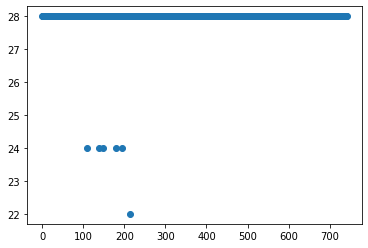

In [59]:
plt.scatter(df_agg.index, df_agg[('keys', 'max')])

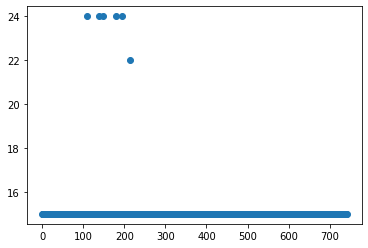

In [60]:
plt.scatter(df_agg.index, df_agg[('keys', 'min')])

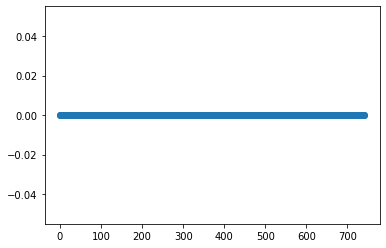

In [61]:
plt.scatter(df_agg.index, df_agg[('max_array_length', 'min')])

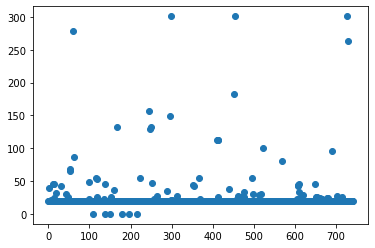

In [62]:
plt.scatter(df_agg.index, df_agg[('max_array_length', 'max')])

Q: Which keys occur in which rows? Do all keys occur in all rows?